In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Monte Carlo Simulation ###

The value of an option is the risk-neutral expectation of its discounted payoff, when the underlying asset price follows a GBM.

Under risk-neutral probability, the asset price GBM is
$$
dS = (r-d) S dt +\sigma S dW(t)
$$

The price of an option determined as average over M simulations is

$$
\hat{C_{0}} = \exp{(-\int_{0}^{T}r dt)}\sum_{j=1}^{M}{C_{T,j}}
$$


In [3]:
def S1_GBM(S0: float, mu: list, sigma: list, T: float, nsteps: int, nsim: int) -> list:
    '''
    S0: initial asset price
    mu: mean rate of asset return
    sigma: asset volatility
    T: time period
    nsteps: number of steps
    nsim: number of simulation of the asset price process
    '''
    dt = T/nsteps
    dw = np.sqrt(dt)*np.random.standard_normal(size=(nsim,nsteps)) # generate the (nsim, nsteps) brownian motion sample
    dz = (mu-0.5*sigma**2)*dt + sigma*dw 
    Sn = np.exp(np.cumsum(dz, axis=1)) # generate the (nsim, nsteps) geometric brownian momtion price process    
    Sn = S0*np.concatenate((np.ones(shape=(nsim,1)),Sn), axis=1) # add the initial value

    return (Sn)


In [4]:
def MC_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Nsteps: int, Nsim: int, optype: str) -> float:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Nsteps: number of time steps to maturity
    Nsim: number of independent simulations to average
    optype: option type ('call' or 'put')
    '''
        
    mu = r-div

    dt = T/Nsteps
    nu = (r-div)-0.5*sigma**2
    dfact = r*dt + np.zeros(Nsteps)

    # parameter exception
    if ((0<r) and (0<sigma) and (0<div)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    Smat = S1_GBM(S0=S0, mu=mu, sigma=sigma, T=T, nsteps=Nsteps, nsim=Nsim)
    Sarr = Smat[:,-1] # stock price at maturity
    Parr = Sarr-K # payoff

    if optype == 'call':
        Parr[Parr<0] = 0
        Parr = Parr
    elif optype == 'put':
        Parr[Parr>0] = 0
        Parr = -Parr
    else: raise Exception('optype must be call or put')

    V0arr = np.exp(-np.sum(dfact))*Parr

    return(np.mean(V0arr))   


In [28]:
price=MC_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Nsteps=10, Nsim=500, optype='call')
print(np.round(price,3))

9.412


Text(0.5, 1.0, 'price convergence: MonteCarlo')

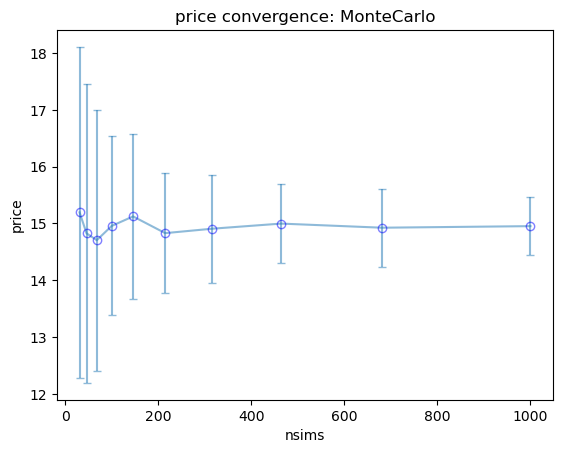

In [16]:
# calculate parameters
S0=100
K=90
r=0.06
sigma=0.2
div=0.03
T=1
Nsteps=10

NSims=np.logspace(1.5,3,10).astype(int) # simulation sizes

price_mean=[]
price_std=[]
for nsim in NSims:
    price_arr=[]
    for ntrials in range(100):
        price=MC_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=1, Nsteps=Nsteps, Nsim=nsim, optype='call')
        price_arr.append(price)
    price_mean.append(np.mean(price_arr))
    price_std.append(np.std(price_arr))
    
# plot
fig,ax = plt.subplots()
ax.errorbar(NSims, price_mean, yerr=price_std, marker='o', mfc='None', mec='blue', capsize=3, alpha=0.5)
ax.set_xlabel('nsims')
ax.set_ylabel('price')
ax.set_title('price convergence: MonteCarlo')
